In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import display

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
from sklearn.metrics import accuracy_score

In [5]:
df = pd.read_parquet('../data/data_prep.parquet')

In [6]:
df_train = pd.read_parquet('../data/df_train.parquet')
df_val = pd.read_parquet('../data/df_val.parquet')
df_test = pd.read_parquet('../data/df_test.parquet')
df_full_train = pd.read_parquet('../data/df_full_train.parquet')

In [7]:
y_train = np.loadtxt('../data/y_train')
y_val = np.loadtxt('../data/y_val')
y_test = np.loadtxt('../data/y_test')

X_train = np.loadtxt('../data/X_train')
X_val = np.loadtxt('../data/X_val')

### Logistic Regression

In [8]:
model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\User\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [9]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.00899994, 0.2045765 , 0.21225399, ..., 0.13642888, 0.79979376,
       0.83742684])

In [10]:
churn_decision = (y_pred >= 0.5)

In [11]:
(y_val == churn_decision).mean()

0.8034066713981547

In [12]:
# Number of correct predictions

(y_val == churn_decision).sum()

1132

In [13]:
# Accuracy: Number of correct predictions / Total Validation Set

((y_val == churn_decision).sum()) / len(y_val)

0.8034066713981547

### Changing the Threshold of 0.5

In [14]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [15]:
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


#### Plot Accuracy with different thresholds

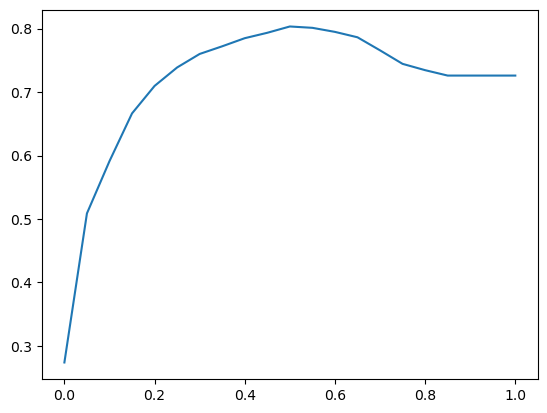

In [16]:
plt.plot(thresholds, scores)
plt.show()

### Ussing sklearn accuracy score

In [17]:
accuracy_score(y_val, y_pred >=0.5)

0.8034066713981547

In [18]:
scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


Accuracy no es la mejor medida en este caso, pues un modelo con threshold de 1 tiene un accuracy alto (72.6%). Esto debido a que hay un desbalanceo de clase, donde solo el 27% de los usuarios ha hecho churn. Es decir, dado que el accuracy mide la cantidad de predicciones correctas, independiente de la clase, el hecho de tener una clase mayoritaria va a llevar a que el modelo genere predicciones correctas en esa clase mayoritaria. Debido a que el caso de uso implica predecir correctamente la clase minoritaria, accuracy no es la medida apropiada.

## Confusion Table

La tabla de confusión es una forma de medir los distintos tipos de errores y decisiones correctas que pueden tomar los clasificadores binarios. Teniendo en cuenta esta información, es posible evaluar la calidad del modelo mediante distintas estrategias.

Cuando se trata de predicciones de un modelo de clasificación binaria, cada predicción se clasifica en una de las cuatro categorías siguientes: 
* La predicción es que el cliente se dará de baja. Esto se conoce como la **clase Positiva** 
    * Y el cliente realmente abandonó - Conocido como Verdadero Positivo (TP) 
    * Pero el cliente realmente no abandonó - Conocido como Falso Positivo (FP) 

* La predicción es que el cliente NO abandonará - Esto se conoce como la **clase Negativa** 
    * El cliente no abandonó - Verdadero Negativo (TN) 
    * El cliente abandonó - Falso Negativo (FN)

<img src="../images/confusion_matrix.png">

In [46]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [47]:
t = 0.5

predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [48]:
true_positive = (predict_positive & actual_positive).sum()
true_negative = (predict_negative & actual_negative).sum()

print('True Positive:', true_positive)
print('True Negative:', true_negative)

True Positive: 210
True Negative: 922


In [49]:
false_positive = (predict_positive & actual_negative).sum()
false_negative = (predict_negative & actual_positive).sum()

print('False Positive:', false_positive)
print('False Negative:', false_negative)

False Positive: 101
False Negative: 176


In [50]:
# Confusion matrix using numpy

confusion_matrix = np.array([
    [true_negative, false_positive],
    [false_negative, true_positive]
])

print(confusion_matrix)

[[922 101]
 [176 210]]


In [51]:
# Confusion matrix %

(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## Precision and Recall

<img src="../images/classification_metrics.png">

### Precision: La precisión nos indica la fracción de predicciones positivas que son correctas. Sólo tiene en cuenta la clase positiva (TP y FP - segunda columna de la matriz de confusión)

Fraction of **positive** predictions that are correct.

Fracción de predicciones **positivas** que son correctas.

$Precision = \frac{TP}{TP + FP}$

In [27]:
precision = true_positive / (true_positive + false_positive)
precision.round(3)

0.675

### Recall: Mide la fracción de casos positivos identificados correctamente. Considera partes de las clases positivas y negativas (TP y FN - segunda fila de la tabla de confusión).

Fraction of correctly identified **positive** examples.

$Recall = \frac{TP}{TP + FN}$

In [28]:
recall = true_positive / (true_positive + false_negative)
recall.round(3)

0.544

## ROC Curve

ROC son las siglas de Receiver Operating Characteristic (Característica Operativa del Receptor), y esta idea se aplicó durante la Segunda Guerra Mundial para evaluar la potencia de los detectores de radio.

Esta medida considera la Tasa de Falsos Positivos (FPR) y la Tasa de Verdaderos Positivos (TPR), que se derivan de los valores de la matriz de confusión. 

* **FPR** es la fracción de falsos positivos (FP) dividida por el número total de negativos (FP y TN - la primera fila de la matriz de confusión), y queremos minimizarla.
$FPR = \frac{FP}{FP + TN}$

* **TPR o Recall** es la fracción de verdaderos positivos (TP) dividida por el número total de positivos (FN y TP - segunda fila de la tabla de confusión), y queremos maximizar esta métrica. 
$TPR = \frac{TP}{TP + FN}$

<img src="../images/TPR_FPR.png">


### TPR and FPR

In [34]:
tpr = round(true_positive / (true_positive + false_negative),3)
fpr = round(false_positive / (false_positive + true_negative),3)
print('TPR:', tpr)
print('FPR:',fpr)

TPR: 0.544
FPR: 0.099


TPR y FPR se calculan usando un solo valor de threshold. ROC Curve evalua estas medidas en todos los valores posibles de threshold

In [61]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [62]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores


,threshold,tp,fp,fn,tn
0,0.00,386,1023,0,0
1,0.01,385,913,1,110
2,0.02,384,830,2,193
3,0.03,383,766,3,257
4,0.04,381,715,5,308
...,...,...,...,...,...
96,0.96,0,0,386,1023
97,0.97,0,0,386,1023
98,0.98,0,0,386,1023
99,0.99,0,0,386,1023


In [63]:
df_scores['TPR'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['FPR'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores

,threshold,tp,fp,fn,tn,TPR,FPR
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,913,1,110,0.997409,0.892473
2,0.02,384,830,2,193,0.994819,0.811339
3,0.03,383,766,3,257,0.992228,0.748778
4,0.04,381,715,5,308,0.987047,0.698925
...,...,...,...,...,...,...,...
96,0.96,0,0,386,1023,0.000000,0.000000
97,0.97,0,0,386,1023,0.000000,0.000000
98,0.98,0,0,386,1023,0.000000,0.000000
99,0.99,0,0,386,1023,0.000000,0.000000


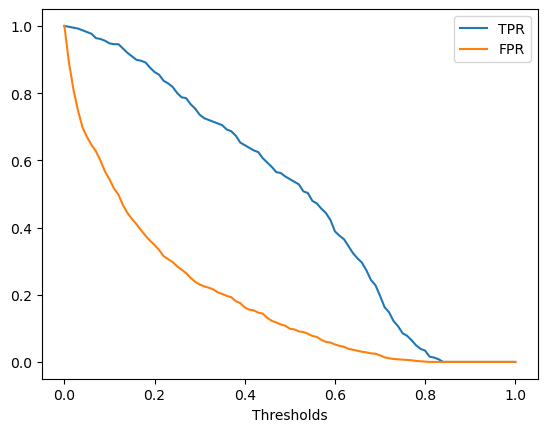

In [66]:
plt.plot(df_scores.threshold, df_scores['TPR'], label = 'TPR')
plt.plot(df_scores.threshold, df_scores['FPR'], label = 'FPR')
plt.xlabel('Thresholds')
plt.legend()
plt.show()

### Random Model

In [67]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [69]:
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [70]:
accuracy_random = ((y_rand >= 0.5) == y_val).mean()
accuracy_random

0.5017743080198722

ROC Curve for Random Model

In [71]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [73]:
df_random = tpr_fpr_dataframe(y_val, y_rand)
df_random[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


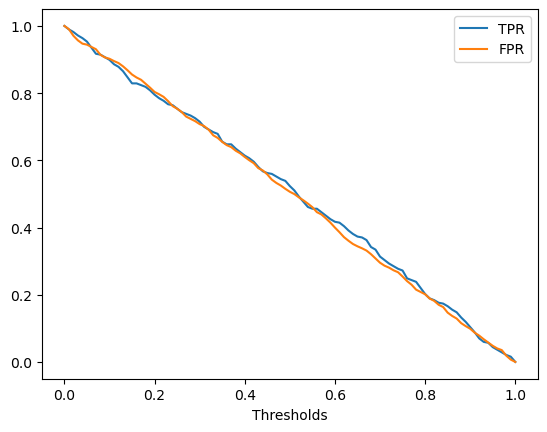

In [75]:
plt.plot(df_random.threshold, df_random['tpr'], label = 'TPR')
plt.plot(df_random.threshold, df_random['fpr'], label = 'FPR')
plt.xlabel('Thresholds')
plt.legend()
plt.show()

# Seguimos en video ROC Curve, vamos a comenzar en el 16:18 ideal model